# FPL with genetic algorithms

In [30]:
using Pkg
Pkg.activate("fpl_genetic", )
Pkg.add("CSV")
Pkg.add("StatsBase")
Pkg.add("Statistics")
Pkg.add("DataFrames")
Pkg.add("Plots")

 Activating environment at `~/Documents/genetic_fpl_julia/fpl_genetic/Project.toml`
  Resolving package versions...
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Project.toml`
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Manifest.toml`
  Resolving package versions...
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Project.toml`
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Manifest.toml`
  Resolving package versions...
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Project.toml`
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Manifest.toml`
  Resolving package versions...
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Project.toml`
No Changes to `~/Documents/genetic_fpl_julia/fpl_genetic/Manifest.toml`
  Resolving package versions...
  Installed Opus_jll ────────── v1.3.1+3
  Installed EarCut_jll ──────── v2.1.5+0
  Installed FreeType2_jll ───── v2.10.1+5
  Installed Ogg_jll ─────────── v1.3.4+2
  Installed Adapt ─

In [51]:
push!(LOAD_PATH, ".")
using CSV
using StatsBase
using Statistics
using DataFrames
using Plots
using FplFuncs
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/duncan/.julia/packages/Plots/5ItHH/src/backends.jl:372


Plots.PlotlyBackend()

### Loading Data

In [3]:
df = DataFrame(CSV.File("./fpl_data.csv"))
df["fitness"] = df.ep_next
# df["fitness"] = fitness.(df.points_per_game, df.form)
first(df, 3)

,first_name,second_name,team,team_code,id,element_type,now_cost
,String,String,Int64,Int64,Int64,Int64,Float64
1,Mesut,Özil,1,3,1,3,6.8
2,Sokratis,Papastathopoulos,1,3,2,2,4.9
3,David,Luiz Moreira Marinho,1,3,3,2,5.5


In [4]:
id_to_player, id_to_cost, id_to_element_type, id_to_team, id_to_fitness = FplFuncs.fpl_get_dicts(df);

### Demoing functions

In [5]:
formation = FplFuncs.fpl_generate_formation()

(1, 4, 4, 2)

In [6]:
initial_squad = FplFuncs.fpl_generate_squad_initial(df)

15-element Array{Int64,1}:
 573
 186
 313
 521
 568
 435
 335
 392
 180
 322
 304
 206
 344
 579
 103

In [7]:
team_from_squad = FplFuncs.fpl_generate_team_from_squad(initial_squad, id_to_element_type)

15-element Array{Int64,1}:
 186
 568
 521
 335
 435
 313
 206
 322
 103
 344
 579
 573
 392
 180
 304

In [8]:
FplFuncs.fpl_print_squad_names(initial_squad, id_to_player)

573 Olsen
186 Rodák
313 Wan-Bissaka
521 Carter-Vickers
568 Telles
435 Cresswell
335 Yedlin
392 Rodrigues Moura da Silva
180 Kebano
322 Ritchie
304 Pereira
206 Roberts
344 McGoldrick
579 Slimani
103 Giroud


In [9]:
FplFuncs.fpl_squad_cost(initial_squad, id_to_cost)

76.39999999999999

In [10]:
FplFuncs.fpl_team_fitness(initial_squad, id_to_fitness)

13.2

In [11]:
FplFuncs.fpl_most_from_one_squad(initial_squad, id_to_team)

3

In [12]:
FplFuncs.fpl_validate_player_types(initial_squad, id_to_element_type)

false

In [13]:
FplFuncs.fpl_players_unique(initial_squad)

true

In [14]:
FplFuncs.fpl_get_player_types(initial_squad, id_to_element_type)

Squad types: [2.0, 5.0, 5.0, 3.0]


4-element Array{Float64,1}:
 2.0
 5.0
 4.0
 0.0

In [15]:
FplFuncs.fpl_print_player_types(initial_squad, id_to_element_type)

Squad types: [2.0, 5.0, 5.0, 3.0]
[2.0, 5.0, 4.0, 0.0]


In [16]:
FplFuncs.fpl_validate_squad(initial_squad, id_to_cost, id_to_team, id_to_element_type)

false

In [17]:
FplFuncs.fpl_iterate_valid_team(df,id_to_element_type,id_to_cost, id_to_team)

15-element Array{Int64,1}:
  99
 545
 292
 520
 428
  79
 553
 485
 420
 381
  87
 267
  10
 530
  49

### Set up a new team - from scratch

In [61]:
p = plot()

pool_size = 200
generations = 1000
early_stop_lim = 200

pool = zeros(Int64, (pool_size, 15))
fitnesses = zeros(pool_size);
max_pool = zero(pool)
max_fitnesses = zero(fitnesses)
fitness_histories = []

created = 0
while created < pool_size
    squad = FplFuncs.fpl_iterate_valid_team(df,
    id_to_element_type,
    id_to_cost,
    id_to_team
    )
    pool[created+1, :] = squad
    fit = FplFuncs.fpl_team_fitness(squad, id_to_fitness)
    fitnesses[created+1] = fit
    created += 1
end

max_fitness = 0
early_stop_count = 0

for generation in collect(1:generations)
    println("Generation: ", generation)
    new_pool = zero(pool)
    new_fitnesses = zero(fitnesses)
    parents, parent_fitness = FplFuncs.fpl_select_best_rows(pool,
        fitnesses,
        50
    )
    created=0
    while created < pool_size
        new_squad = FplFuncs.fpl_iterate_breed(parents,
            df,
            id_to_cost,
            id_to_team,
            id_to_element_type
        )
        new_pool[created+1, :] = new_squad
        new_fitnesses[created+1] = FplFuncs.fpl_team_fitness(new_squad,
            id_to_fitness
        )
        created += 1
    end
    pool = new_pool
    fitnesses = new_fitnesses
    println("Max fitness: ", maximum(fitnesses))
    push!(fitness_histories, maximum(fitnesses))
    if maximum(fitnesses) > max_fitness
        max_fitness = maximum(fitnesses)
        max_pool = pool
        max_fitnesses = fitnesses
        early_stop_count = 0
    elseif early_stop_count <= early_stop_lim
        early_stop_count += 1
    else
        println("Early stopping")
        break
    end
end

Generation: 1
Max fitness: 38.925
Generation: 2
Max fitness: 45.85000000000001
Generation: 3
Max fitness: 41.49999999999999
Generation: 4
Max fitness: 36.85
Generation: 5
Max fitness: 39.2
Generation: 6
Max fitness: 43.45
Generation: 7
Max fitness: 47.150000000000006
Generation: 8
Max fitness: 47.325
Generation: 9
Max fitness: 48.12499999999999
Generation: 10
Max fitness: 47.474999999999994
Generation: 11
Max fitness: 44.9
Generation: 12
Max fitness: 50.525000000000006
Generation: 13
Max fitness: 48.849999999999994
Generation: 14
Max fitness: 48.27499999999999
Generation: 15
Max fitness: 50.425
Generation: 16
Max fitness: 52.5
Generation: 17
Max fitness: 48.55
Generation: 18
Max fitness: 49.9
Generation: 19
Max fitness: 53.925
Generation: 20
Max fitness: 55.525000000000006
Generation: 21
Max fitness: 53.52499999999999
Generation: 22
Max fitness: 52.025000000000006
Generation: 23
Max fitness: 54.52499999999999
Generation: 24
Max fitness: 55.02499999999999
Generation: 25
Max fitness: 53.

Max fitness: 67.5
Generation: 226
Max fitness: 68.30000000000001
Generation: 227
Max fitness: 70.6
Generation: 228
Max fitness: 70.6
Generation: 229
Max fitness: 71.125
Generation: 230
Max fitness: 67.325
Generation: 231
Max fitness: 65.55
Generation: 232
Max fitness: 67.675
Generation: 233
Max fitness: 69.975
Generation: 234
Max fitness: 70.5
Generation: 235
Max fitness: 69.975
Generation: 236
Max fitness: 71.82499999999999
Generation: 237
Max fitness: 71.175
Generation: 238
Max fitness: 72.25
Generation: 239
Max fitness: 72.475
Generation: 240
Max fitness: 73.375
Generation: 241
Max fitness: 72.85
Generation: 242
Max fitness: 76.4
Generation: 243
Max fitness: 72.92499999999998
Generation: 244
Max fitness: 74.475
Generation: 245
Max fitness: 74.45
Generation: 246
Max fitness: 73.14999999999999
Generation: 247
Max fitness: 74.6
Generation: 248
Max fitness: 72.25
Generation: 249
Max fitness: 75.325
Generation: 250
Max fitness: 72.525
Generation: 251
Max fitness: 72.55
Generation: 252
Ma

Max fitness: 78.12499999999999
Generation: 440
Max fitness: 76.74999999999999
Generation: 441
Max fitness: 79.575
Generation: 442
Max fitness: 76.14999999999999
Generation: 443
Max fitness: 76.75
Generation: 444
Max fitness: 78.94999999999999
Generation: 445
Max fitness: 80.175
Generation: 446
Max fitness: 82.74999999999999
Generation: 447
Max fitness: 77.74999999999999
Generation: 448
Max fitness: 77.6
Generation: 449
Max fitness: 77.89999999999999
Generation: 450
Max fitness: 78.27499999999999
Generation: 451
Max fitness: 77.62499999999999
Generation: 452
Max fitness: 77.19999999999999
Generation: 453
Max fitness: 77.32499999999999
Generation: 454
Max fitness: 77.85
Generation: 455
Max fitness: 79.37499999999999
Generation: 456
Max fitness: 79.6
Generation: 457
Max fitness: 82.725
Generation: 458
Max fitness: 78.37499999999999
Generation: 459
Max fitness: 79.07499999999999
Generation: 460
Max fitness: 79.77499999999999
Generation: 461
Max fitness: 81.225
Generation: 462
Max fitness: 

Max fitness: 84.32499999999999
Generation: 646
Max fitness: 87.75
Generation: 647
Max fitness: 84.82499999999999
Generation: 648
Max fitness: 85.99999999999999
Generation: 649
Max fitness: 85.62499999999999
Generation: 650
Max fitness: 86.6
Generation: 651
Max fitness: 86.425
Generation: 652
Max fitness: 85.62499999999999
Generation: 653
Max fitness: 85.87499999999999
Generation: 654
Max fitness: 85.87499999999999
Generation: 655
Max fitness: 88.52499999999999
Generation: 656
Max fitness: 85.925
Generation: 657
Max fitness: 87.925
Generation: 658
Max fitness: 87.49999999999999
Generation: 659
Max fitness: 85.87499999999999
Generation: 660
Max fitness: 85.87499999999999
Generation: 661
Max fitness: 86.69999999999999
Generation: 662
Max fitness: 85.375
Generation: 663
Max fitness: 85.07499999999999
Generation: 664
Max fitness: 85.07499999999999
Generation: 665
Max fitness: 85.07499999999999
Generation: 666
Max fitness: 87.69999999999999
Generation: 667
Max fitness: 85.39999999999999
Gene

Max fitness: 81.675
Generation: 853
Max fitness: 79.675
Generation: 854
Max fitness: 79.325
Generation: 855
Max fitness: 79.0
Generation: 856
Max fitness: 77.8
Generation: 857
Max fitness: 77.9
Generation: 858
Max fitness: 78.02499999999999
Generation: 859
Max fitness: 82.82499999999999
Generation: 860
Max fitness: 78.02499999999999
Generation: 861
Max fitness: 80.29999999999998
Generation: 862
Max fitness: 79.69999999999999
Generation: 863
Max fitness: 79.69999999999999
Generation: 864
Max fitness: 79.14999999999999
Generation: 865
Max fitness: 77.8
Generation: 866
Max fitness: 82.99999999999999
Generation: 867
Max fitness: 79.0
Generation: 868
Max fitness: 82.64999999999999
Generation: 869
Max fitness: 82.57499999999999
Generation: 870
Max fitness: 82.99999999999999
Generation: 871
Max fitness: 83.87499999999999
Generation: 872
Max fitness: 83.57499999999999
Generation: 873
Max fitness: 80.325
Generation: 874
Max fitness: 79.77499999999999
Generation: 875
Max fitness: 82.05
Generatio

In [62]:
plot(collect(1:length(fitness_histories)), fitness_histories,
    legend=false,
    xlabel="Generation",
    ylabel="Maximum Squad fitness")

<!DOCTYPE html>
 
 
 Plots.jl

In [19]:
best_team = max_pool[argmax(max_fitnesses), :]
FplFuncs.fpl_print_squad_names(best_team, id_to_player)

363 McCarthy
298 Maguire
110 Zouma
232 Chilwell
390 Son
306 Rashford
37 Grealish
141 Zaha
474 Lomba Neto
377 Adams
202 Bamford
217 Schmeichel
435 Cresswell
437 Antonio
498 Castagne


In [20]:
FplFuncs.fpl_team_fitness(best_team, id_to_fitness)

87.925

In [21]:
FplFuncs.fpl_squad_cost(best_team, id_to_cost)

94.19999999999999

In [22]:
typeof(best_team)

Array{Int64,1}

In [23]:
FplFuncs.fpl_print_player_types(best_team, id_to_element_type)

Squad types: [2.0, 5.0, 5.0, 3.0]
[1.0, 3.0, 5.0, 2.0]


### Optimisation of squad

Change one/two players

In [24]:
# chosen_team = [12,
#     41,
#     498,
#     46,
#     110,
#     508,
#     445,
#     105,
#     141,
#     164,
#     224,
#     325,
#     435,
#     137,
#     506]
# print_squad_names(chosen_team)

In [25]:
# Fergus' team
chosen_team = [
    131,
    200,
    255,
    259,
    302,
    254,
    508,
    284,
    262,
    117,
    184,
    99,
    457,
    449,
    146
]
FplFuncs.fpl_print_squad_names(chosen_team, id_to_player)

131 McCarthy
200 Dallas
255 Robertson
259 Alexander-Arnold
302 Borges Fernandes
254 Salah
508 Rodríguez
284 Foden
262 Brewster
117 Werner
184 Mitrović
99 Peacock-Farrell
457 Doherty
449 Soucek
146 Mitchell


In [38]:
pool_size = 200
generations = 1000
early_stop_lim = 200
n_changes = 1  # change here

base_pool = zeros(Int64, (pool_size, 15))
fitnesses = zeros(pool_size);
max_pool = zero(pool)
max_fitnesses = zero(fitnesses)
fitness_histories = []

for i in 1:pool_size
    base_pool[i, :] = chosen_team
end

fitnesses[:] .= FplFuncs.fpl_team_fitness(base_pool[1, :], id_to_fitness)

max_fitness = FplFuncs.fpl_team_fitness(base_pool[1, :], id_to_fitness)
early_stop_count = 0

for generation in collect(1:generations)
    println("Generation: ", generation)
    new_pool = zero(base_pool)
    new_fitnesses = zero(fitnesses)
    parents, parent_fitness = FplFuncs.fpl_select_best_rows(base_pool, fitnesses, 50)
    created = 0
    while created < pool_size
        new_squad = FplFuncs.fpl_iterate_breed(parents,
            df,
            id_to_cost,
            id_to_team,
            id_to_element_type,
            chosen_team,
            n_changes
        )
        new_pool[created+1, :] = new_squad
        new_fitnesses[created+1] = FplFuncs.fpl_team_fitness(new_squad,
        id_to_fitness
        )
        created += 1
    end
    base_pool = new_pool
    fitnesses = new_fitnesses
    println("Maximum fitness: ", maximum(fitnesses))
    push!(fitness_histories, maximum(fitnesses))
    if maximum(fitnesses) > max_fitness
        max_fitness = maximum(fitnesses)
        max_pool = base_pool
        max_fitnesses = fitnesses
        early_stop_count = 0
    elseif early_stop_count <= early_stop_lim
        early_stop_count += 1
    else
        println("Early stopping")
        break
    end
end

Generation: 1
Maximum fitness: 49.35000000000001
Generation: 2
Maximum fitness: 48.95000000000001
Generation: 3
Maximum fitness: 48.95000000000001
Generation: 4
Maximum fitness: 46.650000000000006
Generation: 5
Maximum fitness: 46.650000000000006
Generation: 6
Maximum fitness: 45.65
Generation: 7
Maximum fitness: 44.525
Generation: 8
Maximum fitness: 43.825
Generation: 9
Maximum fitness: 44.95
Generation: 10
Maximum fitness: 43.550000000000004
Generation: 11
Maximum fitness: 43.550000000000004
Generation: 12
Maximum fitness: 44.95
Generation: 13
Maximum fitness: 44.95
Generation: 14
Maximum fitness: 43.75000000000001
Generation: 15
Maximum fitness: 43.35
Generation: 16
Maximum fitness: 44.175000000000004
Generation: 17
Maximum fitness: 43.650000000000006
Generation: 18
Maximum fitness: 43.650000000000006
Generation: 19
Maximum fitness: 43.725
Generation: 20
Maximum fitness: 43.275
Generation: 21
Maximum fitness: 43.35000000000001
Generation: 22
Maximum fitness: 43.825
Generation: 23
Ma

Maximum fitness: 43.725
Generation: 203
Maximum fitness: 44.85
Early stopping


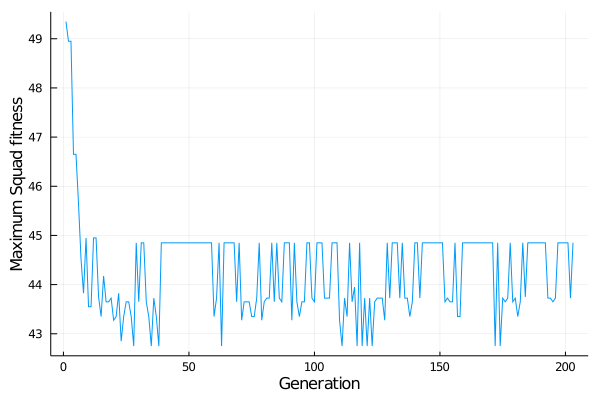

In [39]:
plot(collect(1:length(fitness_histories)), fitness_histories,
    legend=false,
    xlabel="Generation",
    ylabel="Maximum Squad fitness")

In [27]:
FplFuncs.fpl_print_squad_names(chosen_team, id_to_player)
FplFuncs.fpl_team_fitness(chosen_team, id_to_fitness)

131 McCarthy
200 Dallas
255 Robertson
259 Alexander-Arnold
302 Borges Fernandes
254 Salah
508 Rodríguez
284 Foden
262 Brewster
117 Werner
184 Mitrović
99 Peacock-Farrell
457 Doherty
449 Soucek
146 Mitchell


43.75000000000001

In [28]:
best_team = max_pool[argmax(max_fitnesses), :]
FplFuncs.fpl_print_squad_names(best_team, id_to_player)

417 Johnstone
200 Dallas
255 Robertson
259 Alexander-Arnold
302 Borges Fernandes
254 Salah
508 Rodríguez
284 Foden
262 Brewster
117 Werner
184 Mitrović
99 Peacock-Farrell
457 Doherty
449 Soucek
146 Mitchell


In [29]:
FplFuncs.fpl_team_fitness(max_pool[argmax(max_fitnesses), :], id_to_fitness)

49.35000000000001